<font color=gray>Oracle Cloud Infrastructure Data Science Demo Notebook

Copyright (c) 2022 Oracle, Inc.<br>
Licensed under the Universal Permissive License v 1.0 as shown at https://oss.oracle.com/licenses/upl.
</font>

***
# <font color=red>Training a CNN Model to Detect Pneumonia in Patients with X-ray Images  </font>
<p style="margin-left:10%; margin-right:10%;">by the <font color=teal> Oracle Cloud Infrastructure Data Science Team </font></p>

***

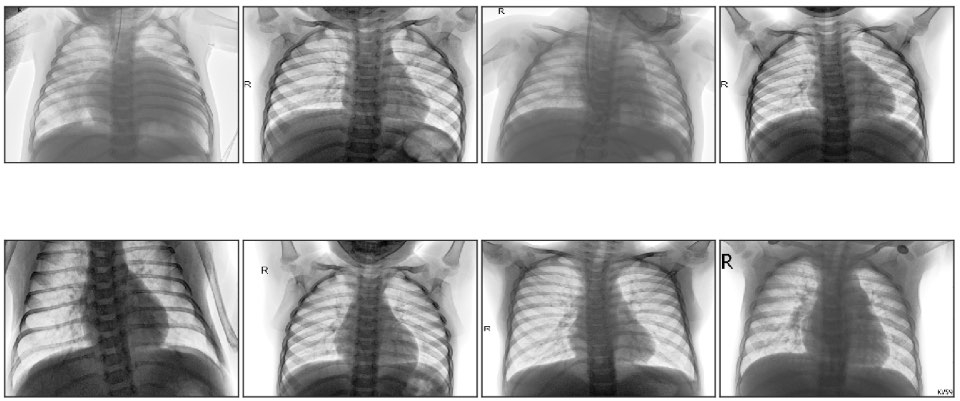

# Introduction 

We're going to see how the Oracle Cloud Infrastructure Data Science service lets us tackle real-world artificial intelligence problems from end to end. To do that we're going to build a complete AI pipeline to detect pneumonia based on a patient's X-ray image. Pneumonia affects about a million Americans per year and causes about 50,000 deaths, making it a top-ten leading cause of death. It's estimated the US will have a shortage of more than 100,000 physicians by the year 2030. AI may help fill this gap by assisting diagnosis, letting us detect pneumonia earlier, with less reliance on medical specialists.

In this notebook demo, we are going to use a convolutional neural network (CNN) to classify chest X-ray images of patients with and without pneumonia. 

**This notebook is inspired from this [notebook](https://www.kaggle.com/code/superlogick/cnn-transfer-learning-pneumonia) on Kaggle.**

## Dataset

We are leveraging the [Labeled Optical Coherence Tomography (OCT) and chest X-ray images](https://data.mendeley.com/datasets/rscbjbr9sj/2) dataset of patients for a supervised binary classification task.  Supervised learning is a machine learning task where the training data has labels that the machine learning model is trying to classify or predict.  

First thing we are going to do is import all the relevant libraries we are going to need, including Keras. 

In [ ]:
!python3 -m pip install oracle-ads --upgrade 

In [ ]:
!pip install scikit-image

In [ ]:
import ads 
print(ads.__version__)

In [ ]:
%load_ext autoreload
%autoreload 2

import os 
import ocifs
from ocifs import OCIFileSystem
from zipfile import ZipFile 
import random
import shutil
import ads
from ads.dataset.factory import DatasetFactory

import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt

from utilities import display_xray_image, display_rows_images, create_df

## Loading the dataset 

The dataset is a zip archive file that we stored on Oracle Cloud Infrastructure Object Storage. We created a pre-authenticated request URL to easily transfer the data onto the notebook container. 

In [ ]:
%%time
# Using resource principal for authenticating with OCI Object Storage
fs = OCIFileSystem(region="us-ashburn-1")

# Creating the local directory 
dirpath = f"./data/"
if not os.path.exists(dirpath):
    os.makedirs(dirpath)

# Downloading the data from Object Storage using OCIFS (https://github.com/oracle/ocifs)
if os.path.exists(os.path.join(dirpath, "chest_xrays.zip")):
    with ZipFile(os.path.join(dirpath, "chest_xrays.zip"), 'r') as zipf:
        zipf.extractall(dirpath)
else:
    fs.download('oci://hosted-ds-datasets@bigdatadatasciencelarge/chest-xrays/ChestXRay2017.zip',os.path.join(dirpath, "chest_xrays.zip"))
    with ZipFile(os.path.join(dirpath, "chest_xrays.zip"), 'r') as zipf:
        zipf.extractall(dirpath)

The data is divided into a `train/` and a `test/` folder. Each folder has images further separated into the `NORMAL/` and `PNEUMONIA/` medical diagnoses. These folders will serve as labels for our binary classification use case. 

The train set contains 3,883 X-rays of patients with pneumonia while there are 1,349 X-ray images of patients who are not diagnosed with the illness. This dataset is considered to be imbalanced for machine learning purposes. 

In [ ]:
train_dir = "./data/chest_xray/train/"
test_dir = "./data/chest_xray/test/"
valid_dir = f"./data/chest_xray/validation/"
if not os.path.exists(valid_dir):
    os.makedirs(valid_dir)
    
normal_train = "./data/chest_xray/train/NORMAL/"
pneumonia_train = "./data/chest_xray/train/PNEUMONIA/"

normal_images = os.listdir(normal_train)
pneumonia_images = os.listdir(pneumonia_train)

valid_dir_normal = os.path.join(valid_dir,"NORMAL")
if not os.path.exists(valid_dir_normal):
    os.makedirs(valid_dir_normal)

valid_dir_pneumonia = os.path.join(valid_dir,"PNEUMONIA")
if not os.path.exists(valid_dir_pneumonia):
    os.makedirs(valid_dir_pneumonia) 
        
# validation sample:     
nb_validation_normal = 8 
nb_validation_pneumonia = 8 

validation_normal_files = random.sample(normal_images, k=nb_validation_normal)
validation_pneumonia_files = random.sample(pneumonia_images, k=nb_validation_pneumonia) 

for x in validation_normal_files: 
    shutil.move(os.path.join(normal_train,x),os.path.join(valid_dir_normal,x))

for x in validation_pneumonia_files: 
    shutil.move(os.path.join(pneumonia_train,x),os.path.join(valid_dir_pneumonia,x))

In [ ]:
f_pneumonia_training = len(os.listdir(pneumonia_train)) / (len(os.listdir(pneumonia_train)) + len(os.listdir(normal_train)))
f_normal_training = 1.0 - f_pneumonia_training
print(f'fraction pneumonia in training dataset : {f_pneumonia_training}')
print(f'fraction normal in training dataset : {f_normal_training}')

# Pneumonia 

Let's plot some of the images in our training dataset where patients have pneumonia.

In [ ]:
plt.figure(figsize=(15, 8))

for i in range(9):
    plt.subplot(3, 3, i + 1)
    img = plt.imread(os.path.join(pneumonia_train, pneumonia_images[i]))
    plt.imshow(img, cmap='gray', origin='upper')
    plt.axis('off')
    
plt.tight_layout()



# Building and Exploring the dataset with ADS DatasetFactory

The first step in the process of training a machine learning model is to build a dataset format that will be understood by the model library. 

We are going to first build a dataframe for both the training and test dataset. The dataset will include metadata about each image. We included the following features: 


* image path
* class(0:normal, 1:pneumonia)
* image dimensions (both x and y) 
* image extension(.jpeg, .png, etc.) 
* number of channels for each image 
* axis ratio (y size / x size ) 

We are going to use the [Oracle Accelerated Data Science (ADS) SDK](https://docs.cloud.oracle.com/iaas/tools/ads-sdk/latest/index.html) to open and explore the dataset. The ADS SDK is a Python library that is included as part of the Oracle Cloud Infrastructure (OCI) Data Science service. ADS offers a friendly user interface, with objects and methods that cover all the steps involved in the lifecycle of machine learning models, from data acquisition to model evaluation and interpretation.

We are going to use the ADS `DatasetFactory` class to load the dataset into a dataframe.

In [ ]:
train_df2 = create_df(dirpath)
ads_df = DatasetFactory.open(train_df2.drop(["resized_image", "original_dims", "dims"], axis=1)).set_target("class")

## Data Profiling 

You can visualize the dataset overall by using the ADS `show_in_notebook` method. It gives you a comprehensive preview of all the basic information about this dataset, including the type of the dataset (whether it’s a regression, binary classification, or multi-class classification dataset), the number of columns and rows, feature types of each columns, visualization of each column, the correlation map, and a short dataset header.


In [ ]:
ads_df.show_in_notebook()

In [ ]:
ads_df.plot(x="original_xsize", y="original_ysize")

In the chart below, we leverage ADS to look at the distribution of axis ratios in the orginal images. Axis ratio here is being defined as the y-axis image length divided by the x-axis image length. This information will help us resize these images to a common size without introducing too many distortions. 

In [ ]:
ads_df.plot(x="original_axis_ratio")

# Image Preprocessing

We're going to use the `ImageDataGenerator()` function in Keras to standardize and augment the data. Images will have : 
* size of (180, 180) pixels
* mean pixel value of 0 
* standard deviation of 1 
* three channels (RGB) - Images with a single channel will have those channel values replicated for all three channels. The pre-trained models expect images with three channels.

Images will also be randomly rotated, flipped, zoomed in and out, shifted, and stretched. 

In [ ]:
from keras.preprocessing.image import ImageDataGenerator

image_generator = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    samplewise_center=True,
    samplewise_std_normalization=True
)

In [ ]:
train = image_generator.flow_from_directory(train_dir, 
                                            batch_size=8, 
                                            shuffle=True, 
                                            class_mode='binary',
                                            target_size=(180, 180))

validation = image_generator.flow_from_directory(valid_dir, 
                                                batch_size=1, 
                                                shuffle=False, 
                                                class_mode='binary',
                                                target_size=(180, 180))


test = image_generator.flow_from_directory(test_dir, 
                                            batch_size=1, 
                                            shuffle=False, 
                                            class_mode='binary',
                                            target_size=(180, 180))

In [ ]:
class_weight = {0: f_pneumonia_training, 1: f_normal_training}

# Custom Model Training

We are going to define the architecture of a convolutional neural network (CNN) to train on our set of X-ray images. A convolution neural network (CNN) is a type of deep learning model commonly used for image classification problems.  Our CNN model consists of 

- Convolutional Layer
- Pooling Layer
- Fully-connected Layer

In the convolutional layer, the input image goes through a set of convolutional filters. The filters have different weights, and they are applied to an area of the input image where  an operation called a convolution is performed in order to extract features.  The filters are moved through the input image.  The pooling layer is used to reduce the number of parameters.  It is similar to the convolution layer in that a filter is moved through the input and an aggregation function is applied to the input (e.g., maximum value of input area, average value of input area).  Finally the fully-connected layer is used to aggregate the final feature map and generate a classification. 

We are going to use [Keras](https://keras.io/) to build our CNN model.  


In [ ]:
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPool2D, Dropout, Flatten, BatchNormalization


model = Sequential()

model.add(Conv2D(filters=32, kernel_size=(3, 3), input_shape=(180, 180, 3), activation='relu'))
model.add(BatchNormalization())
model.add(Conv2D(filters=32, kernel_size=(3, 3), input_shape=(180, 180, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))

model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))

model.add(Conv2D(filters=128, kernel_size=(3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(Conv2D(filters=128, kernel_size=(3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.2))

model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', 
              optimizer='adam', 
              metrics=['accuracy'])

In [ ]:
%%time
r = model.fit(
    train, 
    epochs=10,
    class_weight=class_weight,
    steps_per_epoch=100,
    validation_steps=25,
)

In [ ]:
evaluation = model.evaluate(test)
print(f"Test Accuracy: {evaluation[1] * 100:.2f}%")

evaluation = model.evaluate(train)
print(f"Train Accuracy: {evaluation[1] * 100:.2f}%")

# Transfer Learning -- VGG16 Model 

Rather than defining a model architecture, we can also use transfer learning to train a model. Transfer learning uses a pre-trained model that has typically been trained on a large dataset as a starting point for training another model. We are going to use the [VGG-16](https://www.robots.ox.ac.uk/~vgg/research/very_deep/) model, which is a convolution neural network model trained on images from the ImageNet database.

First, we are going to load the VGG16 Model.

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.applications import VGG16, InceptionV3
from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D, Dropout, Flatten, BatchNormalization
from tensorflow.keras.metrics import Accuracy, Precision, Recall
from tensorflow.keras.optimizers import Adam

vgg16_base_model = VGG16(input_shape=(180,180,3),
                         include_top=False, 
                         weights='imagenet')

In [ ]:
vgg16_model = Sequential([
        vgg16_base_model,
        GlobalAveragePooling2D(),
        Dense(512, activation="relu"),
        BatchNormalization(),
        Dropout(0.6),
        Dense(128, activation="relu"),
        BatchNormalization(),
        Dropout(0.4),
        Dense(64,activation="relu"),
        BatchNormalization(),
        Dropout(0.3),
        Dense(1,activation="sigmoid")
    ])

In [ ]:
optimizer = Adam(learning_rate=0.001)
METRICS = ['accuracy', 
           Precision(name='precision'),
           Recall(name='recall')]

vgg16_model.compile(optimizer=optimizer,
                    loss='binary_crossentropy',
                    metrics=METRICS)



In [ ]:
%%time
r = vgg16_model.fit(train,
          epochs=10,
          class_weight=class_weight,
          steps_per_epoch=100,
          validation_steps=25)

In [ ]:
evaluation =vgg16_model.evaluate(test)
print(f"Test Accuracy: {evaluation[1] * 100:.2f}%")

evaluation = vgg16_model.evaluate(train)
print(f"Train Accuracy: {evaluation[1] * 100:.2f}%")

In [ ]:
vgg16_model.save("./vgg16.tf",save_format='tf')

# Preparing a Model Artifact and Saving The Model to the Model Catalog 

The model catalog is a centralized and managed repository of model artifacts. A model artifact is a ZIP archive that contains the files (`score.py`, `runtime.yaml`, and other files) needed to load and run the model.  The model catalog ensures that model artifacts are immutable.  It allows data scientists to share models and reproduce them as needed. We are going to use `ADS` to prepare the model artifacts and save them to the model catalog. Within `ADS`, you can use the `.prepare()` method that will create the templated model artifacts. 

**Note:** For this example, we will have to change one of the templated model artifacts files to modify the data passed into the model.


## TensorFlowModel 

In [ ]:
import tempfile
from ads.catalog.model import ModelCatalog
from ads.common.model_metadata import UseCaseType
from ads.model.framework.tensorflow_model import TensorFlowModel

ads.set_auth(auth='resource_principal')

tensorflow_model = TensorFlowModel(estimator=vgg16_model, artifact_dir="./tensorflowmodel/")

tensorflow_model.prepare(
     inference_conda_env="tensorflow27_p37_cpu_v1",
     training_conda_env="tensorflow27_p37_cpu_v1",
     use_case_type=UseCaseType.BINARY_CLASSIFICATION,
     force_overwrite=True)

<span style="color:red;font-weight:700;font-size:20px">Stop and complete these instructions before proceeding.</span>

**Important:** Before you can move to the next step, go to the `tensorflowmodel` folder, open the `score.py`, and add in the lines below in the `deserialize()` function: 

<code> if isinstance(data, bytes):
    import pickle
    return pickle.loads(data) </code>
          
and delete the lines:

<code>if isinstance(data, bytes):
    logging.warning(
    "bytes are passed directly to the model. If the model expects a specific data format, you need to write the conversion logic in `deserialize()` yourself."
    )
    return data </code>

In [ ]:
tensorflow_model.reload()

Next, pass an image as a payload to the model endpoint. The image is an numpy narray that will be serialized as a pickle object 

In [ ]:
ndarray_image = test.next()[0]

import pickle 
image_as_bytes = pickle.dumps(ndarray_image)

Verify the prediction before you save the model to the catalog: 

In [ ]:
tensorflow_model.verify(image_as_bytes)

Saving the model to the catalog: 

In [ ]:
model_id = tensorflow_model.save()

# Deploying a model

After a model is saved to the model catalog, it becomes available for deployment as a Model Deployment resource. Model deployment allows you to deploy machine learning models as web applications (HTTP endpoints). It provides real-time predictions and enables you to quickly productionalize your models.
We are going to deploy and invoke the model using `ADS`.

In [ ]:
tensorflow_model.deploy()

In [ ]:
tensorflow_model.summary_status()

# Invoking the Deployed Model with ADS

At this point, typically an external application would interface with the Model Deployment to pass in data and receive back a prediction. In this case we are going to use `ADS` to invoke our model as an example:

1. Go to your Project page.  
2. Under Resources, click on "Model deployments."
3. Click on the name of the Model Deployment you have just created.  
4. Under "General Information", copy the OCID and paste in the in the cell below, replacing "your-model-deployment-id".


In [ ]:
import ads 
from ads.model.deployment import ModelDeployer

ads.set_auth(auth='resource_principal')

deployer = ModelDeployer()
#existing_deployment = deployer.get_model_deployment(model_deployment_id="your-model-deployment-id")
existing_deployment = deployer.get_model_deployment(model_deployment_id="ocid1.datasciencemodeldeployment.oc1.iad.amaaaaaanif7xwiaceus7c6irzfcq6qpbo3ogpljqwvjnuruutxr46jvp5hq")

In [ ]:
existing_deployment.predict(data=image_as_bytes)